# Análise Exploratória dos Dados (_Exploratory Data Analysis_ - EDA)

__Autoria:__ Sabrina Paes Leme P. Correa (paeslemesa@gmail.com) <br>
__Criação:__ 16/04/2024 <br>
__Modificação:__ 16/04/2024

__Descrição:__ Este tutorial mostra como fazer uma análise exploratória de dados usando ferramentas estatísticas. A minha recomendação é usar este material como base, mas não se esqueça de explorar diferentes métodos e estatísticas.

__Referências:__ 
* https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html

## 1. Importando bibliotecas e dados

In [1]:
from pathlib import Path # para manipulação de arquivos

import numpy as np # para manipulação de arrays

import pandas as pd # para manipulação de dataframes


# Vamos nos basear nestas três bibliotecas para alguns gráficos
import matplotlib.pyplot as plt # para plotar gráficos
import seaborn as sns # para plotar gráficos
import plotly.express as px # para plotar gráficos

Vamos abrir o arquivo CSV que geramos do [Tutorial 4](https://github.com/paeslemesa/tutoriaisPython/blob/main/05_Transformar_Shapes_em_Amosrtas_ML.ipynb), onde são amostras das bandas RGB + NIR do Sentinel-2 de uma área da Amazônia.

Para acessar este arquivo CSV: https://raw.githubusercontent.com/paeslemesa/tutoriaisPython/main/amostras_aoi.csv

Estamos trabalhando aqui com quatro classes:
* 1 - Floresta
* 2 - Agua
* 3 - Pastagem
* 4 - Solo Exposto

In [2]:
diretorio = Path("D:/Pesquisa/Artigo_Mestrado/00_Dados") # lembre-se de colocar "barra (/)" ao invés de "contra-barra (\)"

arquivo = Path(diretorio, "amostras_aoi.csv") # arquivo que vamos abrir, está em CSV

In [3]:
df = pd.read_csv(arquivo) # abrindo o arquivo CSV
df.head()

,classe,azul,verde,vermelho,nir,ndvi
0,1,0.1323,0.1467,0.1256,0.4272,0.545586
1,1,0.1291,0.1460,0.1251,0.4213,0.542094
2,1,0.1262,0.1460,0.1221,0.3980,0.530475
3,1,0.1255,0.1438,0.1215,0.4216,0.552569
4,1,0.1281,0.1429,0.1236,0.3646,0.493650


Vamos calcular outro índice além do NDVI, o EVI. <br>
O Enhanced Vegetation Index (EVI) é um índice de vegetação que corrige alguns problemas do NDVI <br>
O EVI é mais sensível a mudanças na cobertura do solo e na estrutura da vegetação. E é calculado da seguinte forma:

$EVI = G \cdot \frac{(NIR - RED)}{(NIR + C1 \cdot RED - C2 \cdot BLUE + L)}$

Onde: <br>
$G = 2.5$ <br>
$C1 = 6$<br>
$C2 = 7.5$<br>
$L = 1$

In [4]:
# adiciondo o EVI

df['evi'] = 2.5 * (df['nir'] - df['vermelho']) / (df['nir'] + 6 * df['vermelho'] - 7.5 * df['azul'] + 1)

## 2. Analisando dados por classe

O primeiro ponto que gosto de estudar é a quantidade de amostras por classe. Como as amostras foram coletadas de shapefiles, eu não tive controle exato da quantidade de pixels por classe. O que eu fiz foi calcular a somatória de área dos shapes de cada classe e já sabia que existiam muito mais amostras de Floresta que tudo.

Escolhi por deixar para filtrar por aqui no tutorial.

Para a gente contar a quantidade de amostras por classes, a gente usa a função <code>groupby</code> (agrupar por) e vamos selecionar a opção <code>count</code> (contar). <br>


In [5]:
df.groupby(by = "classe").count()

,azul,verde,vermelho,nir,ndvi,evi
classe,,,,,,
1,48619,48619,48619,48619,48619,48619
2,92864,92864,92864,92864,92864,92864
3,26622,26622,26622,26622,26622,26622
4,35330,35330,35330,35330,35330,35330


Eu tenho preferência por treinar modelos de Machine Learning (ML) com a mesma quantidade de amostras por classe para evitar enviesar o modelo. Então, eu vou assumir que minha quantidade de amostras por classe vai ser a mínima, <code>26 622</code>, da classse de __Solo Exposto__. E daí vou selecionar aleatoriamente este número de amostras das outras classes.

Agora, para selecionar as amostras, vou fazer essa amostragem, selecionando <code>n</code> como o número de amostras e <code>random_state</code> para gerarmos um estado aleatório reprodutível, de forma que possamos rodar de novo o algoritmo e gerar os mesmos dados. O número 42 é a resposta para "_questão fundamental da vida, do universo, e de tudo mais_"*



<span style="color:grey">*_Quote do Guia do Mochileiro das Galáxias_</span>.

In [6]:
amostras = df.groupby(by='classe').sample( n = 26622, random_state= 42)
amostras.head()

,classe,azul,verde,vermelho,nir,ndvi,evi
4206,1,0.1320,0.1496,0.1284,0.4209,0.532496,0.608716
26998,1,0.1243,0.1372,0.1189,0.4015,0.543044,0.597387
60356,1,0.1286,0.1457,0.1259,0.4316,0.548341,0.625153
19645,1,0.1314,0.1516,0.1290,0.4216,0.531420,0.604495
62270,1,0.1275,0.1476,0.1227,0.4228,0.550137,0.623779


Se quisermos conferir, o resultado, basta contar o número de amostras por classe novamente:

In [7]:
amostras.groupby(by = "classe").count()

,azul,verde,vermelho,nir,ndvi,evi
classe,,,,,,
1,26622,26622,26622,26622,26622,26622
2,26622,26622,26622,26622,26622,26622
3,26622,26622,26622,26622,26622,26622
4,26622,26622,26622,26622,26622,26622


### 2.1. Estudando Histogramas

Eu particularmente gosto muito de usar o pacote Seaborn porque ele trabalha junto com o Matplotlib para gerar gráficos e são fáceis de editar. Aqui eu estou gerando analisando apenas as bandas que temos.

Analisando as bandas, só pelo NIR a gente já percebe que a grande maioria dos pixels da classe 2 (água) se separam dos outros. Mas que devemos precisar de índices como o NDVI ou o EVI (ou até mesmo outros) para separa as demais classes.<br>
O vermelho consegue separa solo exposto (classe 4) de uma certa forma, embora o NDVI ajude mais. <br>
Para podermos separar a classe floresta de pastagem, provavelmente usaremos o verde e o NDVI ou EVI com mais ênfase no modelo.

Analisar como as classes tendem a se comportarem é uma forma de percebermos quais bandas provavelmente serão mais importantes para o nosso modelo, o que é uma análise mais superficial que gera a um processo de "_Data Mining_" (Mineração de Dados). Podemos ver, por exemplo, que a banda azul não é tão crucial assim quanto as outras.

Outra sugestão é fazer testes de normalidade entre as bandas. Para metodologias paramétricas, como o MaxVer, é necessário que nossos dados sigam distribuição normal. Mas metodologias não paramétricas, como o SVM, KNN, Random Forest e até mesmo redes neurais, isso já não é mais necessário.

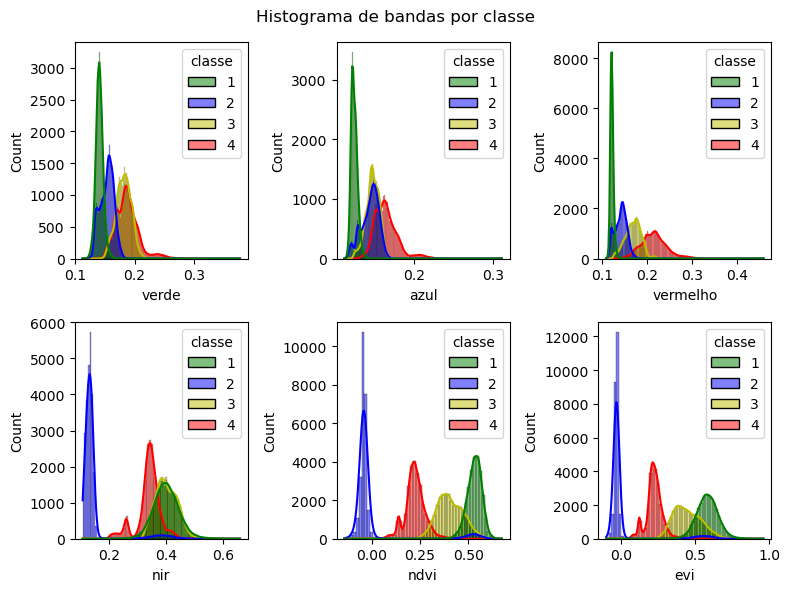

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(8, 6))

sns.histplot(data = amostras, x = "verde",    hue = "classe", kde = True, ax = ax[0,0], palette=['g', 'b', 'y', 'r'])
sns.histplot(data = amostras, x = "azul",     hue = "classe", kde = True, ax = ax[0,1], palette=['g', 'b', 'y', 'r'])
sns.histplot(data = amostras, x = "vermelho", hue = "classe", kde = True, ax = ax[0,2], palette=['g', 'b', 'y', 'r'])
sns.histplot(data = amostras, x = "nir",      hue = "classe", kde = True, ax = ax[1,0], palette=['g', 'b', 'y', 'r'])
sns.histplot(data = amostras, x = "ndvi",      hue = "classe", kde = True, ax = ax[1,1], palette=['g', 'b', 'y', 'r'])
sns.histplot(data = amostras, x = "evi",      hue = "classe", kde = True, ax = ax[1,2], palette=['g', 'b', 'y', 'r'])

fig.suptitle("Histograma de bandas por classe")


fig.tight_layout()

### 2.2. Extudo do Boxplot

Outra análise que podemos fazer é através do boxplot. Geralmente esta análise é feita para encontrar _outliers_ (dados fora do padrão).

As linhas do boxplot ("grafico de caixa") estão relacionadas aos quartis.

C:\Users\paesl\AppData\Local\Temp\ipykernel_26536\933765865.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = amostras, x = "classe", y = 'azul', ax = ax[0,0], palette=['g', 'b', 'y', 'r'])
C:\Users\paesl\AppData\Local\Temp\ipykernel_26536\933765865.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = amostras, x = "classe", y = 'verde', ax = ax[0,1], palette=['g', 'b', 'y', 'r'])
C:\Users\paesl\AppData\Local\Temp\ipykernel_26536\933765865.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = amostras, x = "classe", y = '

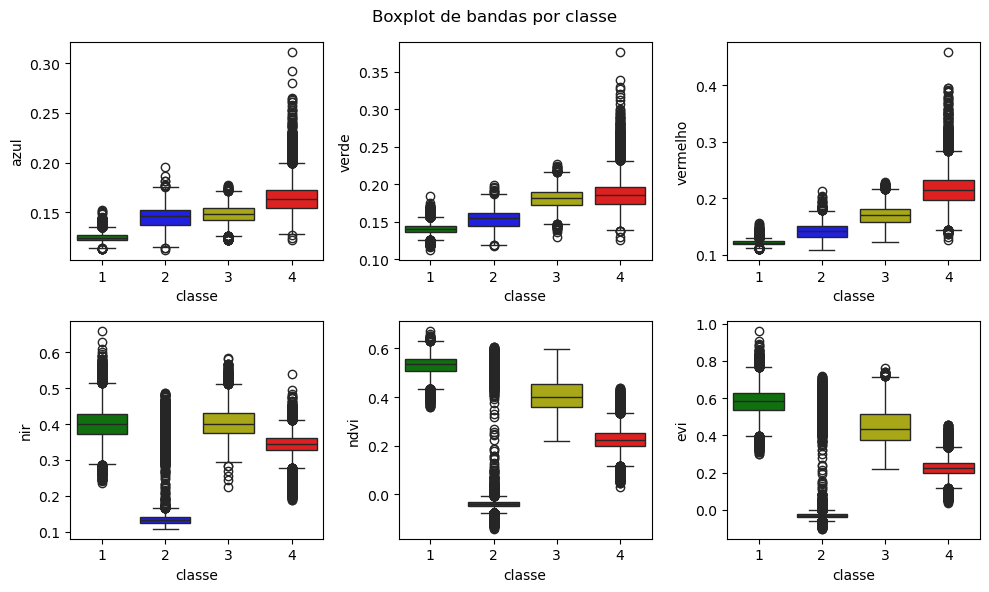

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

sns.boxplot(data = amostras, x = "classe", y = 'azul', ax = ax[0,0], palette=['g', 'b', 'y', 'r'])
sns.boxplot(data = amostras, x = "classe", y = 'verde', ax = ax[0,1], palette=['g', 'b', 'y', 'r'])
sns.boxplot(data = amostras, x = "classe", y = 'vermelho', ax = ax[0,2], palette=['g', 'b', 'y', 'r'])
sns.boxplot(data = amostras, x = "classe", y = 'nir', ax = ax[1,0], palette=['g', 'b', 'y', 'r'])
sns.boxplot(data = amostras, x =  "classe",y = 'ndvi', ax = ax[1,1], palette=['g', 'b', 'y', 'r'])
sns.boxplot(data = amostras, x = "classe", y = 'evi', ax = ax[1,2], palette=['g', 'b', 'y', 'r'])

fig.suptitle("Boxplot de bandas por classe")


fig.tight_layout()

## 3. Analisando Correlação dos Dados

Uma análise que eu gosto muito de fazer é correlacionar todos os nossos dados e ver como eles estão.

Podemos simplesmente selecionar as bandas/feições que queremos estudar a correlação e usar o <code>.corr()</code> no final para gerar uma tabela

In [10]:
amostras_corr = amostras[['azul', 'verde', 'vermelho', 'nir', 'ndvi', 'evi']].corr()
amostras_corr

,azul,verde,vermelho,nir,ndvi,evi
azul,1.000000,0.903742,0.928428,-0.092304,-0.465141,-0.474986
verde,0.903742,1.000000,0.910678,0.249277,-0.140151,-0.146169
vermelho,0.928428,0.910678,1.000000,0.136839,-0.246985,-0.278539
nir,-0.092304,0.249277,0.136839,1.000000,0.914844,0.911138
ndvi,-0.465141,-0.140151,-0.246985,0.914844,1.000000,0.994593
evi,-0.474986,-0.146169,-0.278539,0.911138,0.994593,1.000000


Text(0.5, 0.98, 'Correlação entre as bandas')

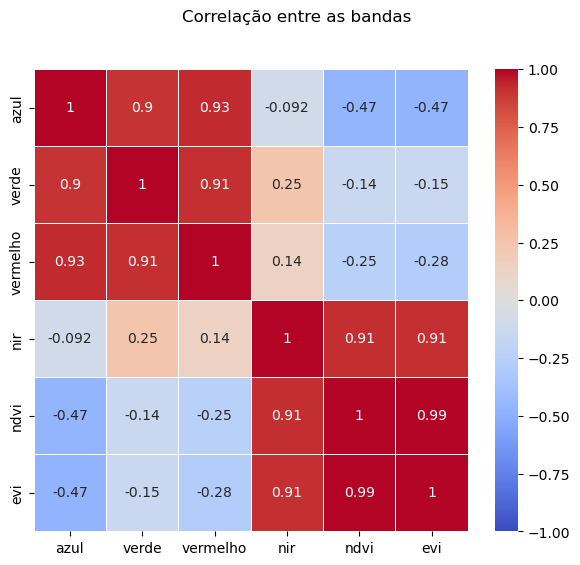

In [14]:
# Para criar um gráfico de correlação, vamos usar a biblioteca Seaborn novamente <3
fig, ax = (plt.subplots(nrows=1, ncols=1, figsize=(7, 6)))

sns.heatmap(amostras_corr, # dataframe com a correlação que calculamos ali em cima
            annot =True, # para mostrar os valores  de correlação no gráfico
            linewidth = 0.5, # para separar as cores com uma linha de espessura 0.5 (recomendo para facilitar visualização para daltônicos
            vmin=-1, # valor mínimo da escala de cores
            vmax=1, # valor máximo da escala de cores
            cmap='coolwarm' # paleta de cores utilizada. você pode selecionar qualquer uma das paletas disponíveis em https://matplotlib.org/stable/tutorials/colors/colormaps.html
            )

fig.suptitle("Correlação entre as bandas")

Ao analisar a matriz de correlação, vemos uma alta correlação entre NRI, NDVI e EVi. E também vemos correlação entre as bandas do RGB.

Por mais que dados muito correlacionados sejam ruins, temos uma certa variação neles. Então vamos ver no que sai.
